In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
from scipy import stats
from tempfile import TemporaryDirectory
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import r2_score
import copy

# Simulate all toy examples. 

In [2]:
def simulate_linear5d_static(k, totalstep):
    eta = np.array([[ 0.02842224],
                    [ 0.54671299],
                    [-0.73645409],
                    [-0.16290995],
                    [-0.48211931]])
    A = np.array([[ 0.59884621,  0.03972211, -0.29245675, -0.78190846, -0.25719224],
                 [ 0.00814218, -0.27560291,  1.29406381,  1.00672432, -2.71116248],
                 [-1.88901325, -0.17477209, -0.42219041,  0.213643,   0.21732193],
                 [ 2.11783876, -1.11202076, -0.37760501,  2.04277161, 0.646703  ],
                 [ 0.66306337, -0.51400637, -1.64807517,  0.16746474, 0.10901409]])
    eigval, eigvec = np.linalg.eig(A)
    eigval[0] -= np.real(eigval[0])
    eigval[1] -= np.real(eigval[1])
    eigval[2] += 1.2
    A1 = eigvec @ np.diag(eigval) @ np.linalg.inv(eigvec)
    A1 = np.real(A1)
    eigval1, eigvec1 = np.linalg.eig(A1)
    
    timestamps = np.arange(k, totalstep*k, k)
    x_traj = [eta]
    for t in timestamps:
        # compute matrix exponential
        E = np.diag(np.exp(eigval1*t))
        x_t = eigvec1 @ E @ np.linalg.inv(eigvec1) @ eta
        # print(x_t)
        assert np.linalg.norm(np.imag(x_t)) < 1e-10
        x_traj.append(np.real(x_t))
    return np.array(x_traj)

In [3]:
def simulate_linear5d_dynamic(k, totalstep):
    eta = np.array([[ 0.02842224],
                    [ 0.54671299],
                    [-0.73645409],
                    [-0.16290995],
                    [-0.48211931]])
    A = np.array([[ 0.59884621,  0.03972211, -0.29245675, -0.78190846, -0.25719224],
                 [ 0.00814218, -0.27560291,  1.29406381,  1.00672432, -2.71116248],
                 [-1.88901325, -0.17477209, -0.42219041,  0.213643,   0.21732193],
                 [ 2.11783876, -1.11202076, -0.37760501,  2.04277161, 0.646703  ],
                 [ 0.66306337, -0.51400637, -1.64807517,  0.16746474, 0.10901409]])
    eigval, eigvec = np.linalg.eig(A)
    eigval[0] -= np.real(eigval[0])
    eigval[1] -= np.real(eigval[1])
    eigval[2] += 1.2
    A1 = eigvec @ np.diag(eigval) @ np.linalg.inv(eigvec)
    A1 = np.real(A1)
    
    a = [[-1, 1, -1, 2, -1]]
    x_traj = [eta]
    W_traj = []
    for i in range(totalstep):
        W = A1 + x_traj[-1] @ a
        x_next = x_traj[-1] + k*W @ x_traj[-1]
        x_traj.append(x_next)
        W_traj.append(W)
    return np.array(x_traj), np.array(W_traj)

In [4]:
def simulate_tanh5d_static(k, totalstep):
    eta = np.array([[ 0.02842224],
                     [ 0.54671299],
                     [-0.73645409],
                     [-0.16290995],
                     [-0.48211931]])
    rng = np.random.default_rng(seed=2)
    A = rng.standard_normal(size=(5, 5))

    eigval, eigvec = np.linalg.eig(A)
    eigval[0] -= 2*eigval[0]
    eigval[1] -= np.real(eigval[1])
    eigval[2] -= np.real(eigval[2])
    A1 = eigvec @ np.diag(eigval) @ np.linalg.inv(eigvec)
    A1 = np.real(A1)
    
    x_traj = [eta]
    for i in range(totalstep):
        x_next = x_traj[-1] + k*np.tanh(A1 @ x_traj[-1])
        x_traj.append(x_next)
    return np.array(x_traj)

In [5]:
def simulate_tanh5d_dynamic(k, totalstep):
    eta = np.array([[ 0.02842224],
                     [ 0.54671299],
                     [-0.73645409],
                     [-0.16290995],
                     [-0.48211931]])
    rng = np.random.default_rng(seed=2)
    A = rng.standard_normal(size=(5, 5))
    
    eigval, eigvec = np.linalg.eig(A)
    eigval[0] -= 2*eigval[0]
    eigval[1] -= np.real(eigval[1])
    eigval[2] -= np.real(eigval[2])
    A1 = eigvec @ np.diag(eigval) @ np.linalg.inv(eigvec)
    A1 = np.real(A1)
    
    a = [[-1, -1, 1, 1, 1]]
    x_traj = [eta]
    W_traj = []
    for i in range(totalstep):
        W = A1 + x_traj[-1] @ a
        x_next = x_traj[-1] + k*np.tanh(W @ x_traj[-1])
        x_traj.append(x_next)
        W_traj.append(W)
    return np.array(x_traj), np.array(W_traj)

In [6]:
def linear5d_static_W_true():
    A = np.array([[ 0.59884621,  0.03972211, -0.29245675, -0.78190846, -0.25719224],
                 [ 0.00814218, -0.27560291,  1.29406381,  1.00672432, -2.71116248],
                 [-1.88901325, -0.17477209, -0.42219041,  0.213643,   0.21732193],
                 [ 2.11783876, -1.11202076, -0.37760501,  2.04277161, 0.646703  ],
                 [ 0.66306337, -0.51400637, -1.64807517,  0.16746474, 0.10901409]])
    eigval, eigvec = np.linalg.eig(A)
    eigval[0] -= np.real(eigval[0])
    eigval[1] -= np.real(eigval[1])
    eigval[2] += 1.2
    A1 = eigvec @ np.diag(eigval) @ np.linalg.inv(eigvec)
    A1 = np.real(A1)
    return A1

In [7]:
def tanh5d_static_W_true():
    rng = np.random.default_rng(seed=2)
    A = rng.standard_normal(size=(5, 5))
    eigval, eigvec = np.linalg.eig(A)
    eigval[0] -= 2*eigval[0]
    eigval[1] -= np.real(eigval[1])
    eigval[2] -= np.real(eigval[2])
    A1 = eigvec @ np.diag(eigval) @ np.linalg.inv(eigvec)
    A1 = np.real(A1)
    return A1

In [8]:
def linear5d_dynamic_W_true(xsteps, k=0.01, totalstep=5000):  # ground-truth time-varying connectivity on test set
    x_traj, W_traj = simulate_linear5d_dynamic(k, totalstep)
    # print(x_traj.shape, W_traj.shape)
    
    W_traj_avg = np.mean(W_traj[2400+xsteps-1:3000+xsteps-1], axis=0)
    return W_traj_avg

In [9]:
def tanh5d_dynamic_W_true(xsteps, k=0.01, totalstep=5000):
    x_traj, W_traj = simulate_tanh5d_dynamic(k, totalstep)
    # print(x_traj.shape, W_traj.shape)
    
    W_traj_avg = np.mean(W_traj[2400+xsteps-1:3000+xsteps-1], axis=0)
    return W_traj_avg

# Define NetFormer model
Since we only used 1-history step in the toy examples, normalization across history steps is not needed. So layernorm is not used in the toy examples (use_LN set to False by default). 

In [10]:
class SingleHeadAttention(nn.Module):
    def __init__(self, nvar, input_dim, emb_dim, use_LN=False, proj_dim=None):
        super(SingleHeadAttention, self).__init__()

        self.input_dim = input_dim  # n hist steps
        self.emb_dim = emb_dim
        self.nvar = nvar  # n var
        self.use_LN = use_LN
        if proj_dim is None:
            self.proj_dim = nvar
        else:
            self.proj_dim = proj_dim
        
        self.E = nn.Parameter(torch.randn(self.nvar, self.emb_dim))
        self.query_linear = nn.Linear(in_features=self.input_dim+self.emb_dim, out_features=self.proj_dim, bias=False)
        self.key_linear = nn.Linear(in_features=self.input_dim+self.emb_dim, out_features=self.proj_dim, bias=False)
        self.layer_norm1 = nn.LayerNorm(normalized_shape=self.input_dim+self.emb_dim)
        self.layer_norm2 = nn.LayerNorm(normalized_shape=self.input_dim)
        
    def forward(self, x):
        batch_size, nvar, input_dim = x.size()
        embedding_batch = self.E.unsqueeze(0).expand(batch_size, -1, -1)   # batch_size, seq_len, emb_dim
        x_with_embedding = torch.cat((x, embedding_batch), -1)
        if self.use_LN:
            x_with_embedding = self.layer_norm1(x_with_embedding)
            
        # Apply linear transformations for queries, keys, and values
        queries = self.query_linear(x_with_embedding)
        keys = self.key_linear(x_with_embedding)
        
        # Compute attention without softmax
        attention_weights = torch.matmul(queries, keys.transpose(-2, -1))  # (batch_size, sequence_length, sequence_length)

        values = x_with_embedding[:, :, :input_dim]
        if len(values.shape) == 2:
            values = torch.unsqueeze(values, 2)
                                    
        # Apply attention weights to values
        attended_values = torch.matmul(attention_weights, values) + values
        if self.use_LN:
            attended_values = self.layer_norm2(attended_values)

        return torch.unsqueeze(attended_values[:, :, -1], 2), attention_weights

In [11]:
class NetFormer(nn.Module):
    def __init__(self, nvar, input_dim, emb_dim, use_LN):
        super(NetFormer, self).__init__()
        self.attention = SingleHeadAttention(nvar, input_dim, emb_dim, use_LN)

    def forward(self, inputs):  # inputs shape: (num_samples, nvar, input_dim)
        x = self.attention(inputs)[0] # (num_samples, nvar)
        return x

## Train & test functions

In [12]:
def train(dataloader, model, criterion, optimizer, device='cpu'):
    model.train()  # turn on train mode
    loss_all_batches = []

    for inp_batch, target_batch in dataloader:  # inp_batch: batch_size, nvar, inp_dim, target_batch: batch_size, nvar, 1
        inp_batch = inp_batch.to(device)
        target_batch = target_batch.to(device)
        target_batch_pred = model(inp_batch)
        loss = criterion(target_batch_pred, target_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_all_batches.append(loss.item())

    return np.sum(loss_all_batches)/len(loss_all_batches)

In [13]:
def evaluate(dataloader, model, criterion, device='cpu'):
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    with torch.no_grad():
        for inp_batch, target_batch in dataloader:
            inp_batch = inp_batch.to(device)
            target_batch = target_batch.to(device)
            target_batch_pred = model(inp_batch)
            total_loss += criterion(target_batch_pred, target_batch).item()

    return total_loss / len(dataloader)

# Run NetFormer with 10 random seeds

In [14]:
mse_allseeds_allmodels_1100epochs = {}  # test set MSE
r2_allseeds_allmodels_1100epochs = {}  # test set R2
spear_cc_allseeds_allmodels_1100epochs = {}  # Spearman correlation between average attention and true connectivity
pearson_cc_allseeds_allmodels_1100epochs = {}  # Pearson correlation between average attention and true connectivity
temp_cc_allseeds_allmodels_1100epochs = {}  # temporal correlation between attention and time-varying connectivity
attn_allseeds_allmodels_1100epochs = {}  # attention matrices on test set
pred_allseeds_allmodels_1100epochs = {}  # activity prediction on test set

## Linear static

In [17]:
x_traj = simulate_linear5d_static(0.01, 5000)
print(x_traj.shape)
inputs = torch.from_numpy(x_traj[7:3000+7, :, :])  # first 7 timesteps were excluded for some historical reasons... not necessary
targets = torch.from_numpy(x_traj[8:3000+8, :, :])  
print(inputs.shape, targets.shape)

# use the most recent timestamps as test set
total = targets.shape[0]
inputs_train = inputs[:int(total*0.8)]
targets_train = targets[:int(total*0.8)]

inputs_test = inputs[int(total*0.8):]
targets_test = targets[int(total*0.8):]

print(inputs_train.shape, targets_train.shape, inputs_test.shape, targets_test.shape)

train_dataset = TensorDataset(inputs_train, targets_train)
test_dataset = TensorDataset(inputs_test, targets_test)
print(len(train_dataset), len(test_dataset))

(5000, 5, 1)
torch.Size([3000, 5, 1]) torch.Size([3000, 5, 1])
torch.Size([2400, 5, 1]) torch.Size([2400, 5, 1]) torch.Size([600, 5, 1]) torch.Size([600, 5, 1])
2400 600


In [18]:
torch.set_default_dtype(torch.float64)
seeds = np.arange(10)
offdiag_mask = ~np.eye(5,dtype=bool)
targets_test_np = targets_test.numpy()
GT = linear5d_static_W_true()
nvar = 5
emb_dim = nvar
input_dim = 1
num_epochs = 1100
    
mse_1100epochs_allseeds = []
r2_1100epochs_allseeds = []
spear_cc_1100epochs_allseeds = []
pearson_cc_1100epochs_allseeds = []
attn_1100epochs_allseeds = []
pred_1100epochs_allseeds = []

for seed in seeds:
    print('seed', seed)
    torch.manual_seed(seed)

    train_dataloader = DataLoader(train_dataset, batch_size=80, shuffle=True)
    model = NetFormer(nvar, input_dim, emb_dim, use_LN=False)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    train_losses = []
    with torch.no_grad():
        test_pred = model(inputs_test)
        loss = criterion(test_pred, targets_test)
        # print(loss.item())

        train_pred = model(inputs_train)
        loss = criterion(train_pred, targets_train)
        # print(loss.item())
        train_losses.append(loss.item())
    
    # Training loop
    for epoch in range(num_epochs):
        train_loss_epoch = train(train_dataloader, model, criterion, optimizer)
        train_losses.append(train_loss_epoch.item())
        
    with torch.no_grad():
        test_pred, test_attn = model.attention(inputs_test)
        mse_1100epochs_allseeds.append(criterion(test_pred, targets_test).item())
        r2_1100epochs_allseeds.append(r2_score(targets_test_np[:,:,0], test_pred.numpy()[:,:,0]))
        avg_attn = np.mean(test_attn.numpy(), axis=0)
        spear_cc_1100epochs_allseeds.append(stats.spearmanr(GT[offdiag_mask].flatten(), avg_attn[offdiag_mask].flatten()).correlation)
        pearson_cc_1100epochs_allseeds.append(np.corrcoef(GT[offdiag_mask].flatten(), avg_attn[offdiag_mask].flatten())[0, 1])
        attn_1100epochs_allseeds.append(test_attn.numpy())
        pred_1100epochs_allseeds.append(test_pred.numpy())

    # plt.semilogy(train_losses, label='train')
    # plt.xlabel('# epoches')
    # plt.ylabel('training loss')
    # plt.title(f'seed {seed}')
    # plt.legend()
    # plt.show()

seed 0
seed 1
seed 2
seed 3
seed 4
seed 5
seed 6
seed 7
seed 8
seed 9


In [19]:
print('mse:', 'mean:', np.mean(mse_1100epochs_allseeds), 'std:', np.std(mse_1100epochs_allseeds), 'min:', np.min(mse_1100epochs_allseeds), 'max:', np.max(mse_1100epochs_allseeds))
print('r2:', 'mean:', np.mean(r2_1100epochs_allseeds), 'std:', np.std(r2_1100epochs_allseeds), 'min:', np.min(r2_1100epochs_allseeds), 'max:', np.max(r2_1100epochs_allseeds))
print('spear:', 'mean:', np.mean(spear_cc_1100epochs_allseeds), 'std:', np.std(spear_cc_1100epochs_allseeds), 'min:', np.min(spear_cc_1100epochs_allseeds), 'max:', np.max(spear_cc_1100epochs_allseeds))
print('pearson:', 'mean:', np.mean(pearson_cc_1100epochs_allseeds), 'std:', np.std(pearson_cc_1100epochs_allseeds), 'min:', np.min(pearson_cc_1100epochs_allseeds), 'max:', np.max(pearson_cc_1100epochs_allseeds))

mse: mean: 7.911075236366587e-10 std: 1.5607547427427196e-09 min: 1.0724176491509301e-19 max: 5.2646334580208496e-09
r2: mean: 0.9999999613968532 std: 8.728897330327916e-08 min: 0.9999997035183661 max: 1.0
spear: mean: 0.9998496240601504 std: 0.0004511278195488688 min: 0.9984962406015038 max: 1.0
pearson: mean: 0.9999695708650668 std: 4.803046230294824e-05 min: 0.9998441620044999 max: 0.9999966191773659


In [20]:
mse_allseeds_allmodels_1100epochs['linear_static'] = mse_1100epochs_allseeds
r2_allseeds_allmodels_1100epochs['linear_static'] = r2_1100epochs_allseeds
spear_cc_allseeds_allmodels_1100epochs['linear_static'] = spear_cc_1100epochs_allseeds
pearson_cc_allseeds_allmodels_1100epochs['linear_static'] = pearson_cc_1100epochs_allseeds
temp_cc_allseeds_allmodels_1100epochs['linear_static'] = {}
attn_allseeds_allmodels_1100epochs['linear_static'] = attn_1100epochs_allseeds
pred_allseeds_allmodels_1100epochs['linear_static'] = pred_1100epochs_allseeds

## tanh static

In [21]:
x_traj = simulate_tanh5d_static(0.01, 5000)
print(x_traj.shape)
inputs = torch.from_numpy(x_traj[7:3000+7, :, :])
targets = torch.from_numpy(x_traj[8:3000+8, :, :])
print(inputs.shape, targets.shape)

# use the most recent timestamps as test set
total = targets.shape[0]
inputs_train = inputs[:int(total*0.8)]
targets_train = targets[:int(total*0.8)]

inputs_test = inputs[int(total*0.8):]
targets_test = targets[int(total*0.8):]

print(inputs_train.shape, targets_train.shape, inputs_test.shape, targets_test.shape)

train_dataset = TensorDataset(inputs_train, targets_train)
test_dataset = TensorDataset(inputs_test, targets_test)
print(len(train_dataset), len(test_dataset))

(5001, 5, 1)
torch.Size([3000, 5, 1]) torch.Size([3000, 5, 1])
torch.Size([2400, 5, 1]) torch.Size([2400, 5, 1]) torch.Size([600, 5, 1]) torch.Size([600, 5, 1])
2400 600


In [22]:
torch.set_default_dtype(torch.float64)
seeds = np.arange(10)
offdiag_mask = ~np.eye(5,dtype=bool)
targets_test_np = targets_test.numpy()
GT = tanh5d_static_W_true()
nvar = 5
emb_dim = nvar
input_dim = 1
num_epochs = 1100

    
mse_1100epochs_allseeds = []
r2_1100epochs_allseeds = []
spear_cc_1100epochs_allseeds = []
pearson_cc_1100epochs_allseeds = []
attn_1100epochs_allseeds = []
pred_1100epochs_allseeds = []

for seed in seeds:
    print('seed', seed)
    
    torch.manual_seed(seed)

    train_dataloader = DataLoader(train_dataset, batch_size=80, shuffle=True)
    model = NetFormer(nvar, input_dim, emb_dim, use_LN=False)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    train_losses = []
    
    with torch.no_grad():
        test_pred = model(inputs_test)
        loss = criterion(test_pred, targets_test)
        # print(loss.item())

        train_pred = model(inputs_train)
        loss = criterion(train_pred, targets_train)
        # print(loss.item())
        train_losses.append(loss.item())
    
    # Training loop
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
    for epoch in range(num_epochs):
        train_loss_epoch = train(train_dataloader, model, criterion, optimizer)
        train_losses.append(train_loss_epoch.item())
        scheduler.step()
        # if epoch%100==0: print(scheduler.get_last_lr())
        
    with torch.no_grad():
        test_pred, test_attn = model.attention(inputs_test)
        mse_1100epochs_allseeds.append(criterion(test_pred, targets_test).item())
        r2_1100epochs_allseeds.append(r2_score(targets_test_np[:,:,0], test_pred.numpy()[:,:,0]))
        avg_attn = np.mean(test_attn.numpy(), axis=0)
        spear_cc_1100epochs_allseeds.append(stats.spearmanr(GT[offdiag_mask].flatten(), avg_attn[offdiag_mask].flatten()).correlation)
        pearson_cc_1100epochs_allseeds.append(np.corrcoef(GT[offdiag_mask].flatten(), avg_attn[offdiag_mask].flatten())[0, 1])
        attn_1100epochs_allseeds.append(test_attn.numpy())
        pred_1100epochs_allseeds.append(test_pred.numpy())
    
    # plt.semilogy(train_losses, label='train')
    # plt.xlabel('# epoches')
    # plt.ylabel('training loss')
    # plt.title(f'seed {seed}')
    # plt.legend()
    # plt.show()

seed 0
seed 1
seed 2
seed 3
seed 4
seed 5
seed 6
seed 7
seed 8
seed 9


In [23]:
print('mse:', 'mean:', np.mean(mse_1100epochs_allseeds), 'std:', np.std(mse_1100epochs_allseeds), 'min:', np.min(mse_1100epochs_allseeds), 'max:', np.max(mse_1100epochs_allseeds))
print('r2:', 'mean:', np.mean(r2_1100epochs_allseeds), 'std:', np.std(r2_1100epochs_allseeds), 'min:', np.min(r2_1100epochs_allseeds), 'max:', np.max(r2_1100epochs_allseeds))
print('spear:', 'mean:', np.mean(spear_cc_1100epochs_allseeds), 'std:', np.std(spear_cc_1100epochs_allseeds), 'min:', np.min(spear_cc_1100epochs_allseeds), 'max:', np.max(spear_cc_1100epochs_allseeds))
print('pearson:', 'mean:', np.mean(pearson_cc_1100epochs_allseeds), 'std:', np.std(pearson_cc_1100epochs_allseeds), 'min:', np.min(pearson_cc_1100epochs_allseeds), 'max:', np.max(pearson_cc_1100epochs_allseeds))

mse: mean: 9.565920822994322e-07 std: 1.0757296366173722e-07 min: 8.378264246942727e-07 max: 1.178043900440454e-06
r2: mean: 0.9999990636367766 std: 1.900452997379868e-07 min: 0.9999986591358552 max: 0.9999992862634091
spear: mean: 0.9030075187969926 std: 0.013981728140845522 min: 0.8766917293233082 max: 0.9293233082706768
pearson: mean: 0.8781633152320371 std: 0.02018980631501892 min: 0.8484052696253999 max: 0.9081289066566237


In [24]:
mse_allseeds_allmodels_1100epochs['tanh_static'] = mse_1100epochs_allseeds
r2_allseeds_allmodels_1100epochs['tanh_static'] = r2_1100epochs_allseeds
spear_cc_allseeds_allmodels_1100epochs['tanh_static'] = spear_cc_1100epochs_allseeds
pearson_cc_allseeds_allmodels_1100epochs['tanh_static'] = pearson_cc_1100epochs_allseeds
temp_cc_allseeds_allmodels_1100epochs['tanh_static'] = {}
attn_allseeds_allmodels_1100epochs['tanh_static'] = attn_1100epochs_allseeds
pred_allseeds_allmodels_1100epochs['tanh_static'] = pred_1100epochs_allseeds

## Linear dynamic

In [25]:
x_traj, W_traj = simulate_linear5d_dynamic(0.01, 5000)
print(x_traj.shape, W_traj.shape)
inputs = torch.from_numpy(x_traj[7:3000+7, :, :]).float()
targets = torch.from_numpy(x_traj[8:3000+8, :, :]).float()
print(inputs.shape, targets.shape)

W_traj_ = W_traj.reshape((W_traj.shape[0], -1))
W_traj_test = W_traj_[2400+7:3000+7]  # time-varying connectivity on the test set

# use the most recent timestamps as test set
total = targets.shape[0]
inputs_train = inputs[:int(total*0.8)]
targets_train = targets[:int(total*0.8)]

inputs_test = inputs[int(total*0.8):]
targets_test = targets[int(total*0.8):]

print(inputs_train.shape, targets_train.shape, inputs_test.shape, targets_test.shape)

train_dataset = TensorDataset(inputs_train, targets_train)
test_dataset = TensorDataset(inputs_test, targets_test)
print(len(train_dataset), len(test_dataset))

(5001, 5, 1) (5000, 5, 5)
torch.Size([3000, 5, 1]) torch.Size([3000, 5, 1])
torch.Size([2400, 5, 1]) torch.Size([2400, 5, 1]) torch.Size([600, 5, 1]) torch.Size([600, 5, 1])
2400 600


In [26]:
torch.set_default_dtype(torch.float32)
seeds = np.arange(10)
offdiag_mask = ~np.eye(5,dtype=bool)
targets_test_np = targets_test.numpy()
GT = linear5d_dynamic_W_true(8)
nvar = 5
emb_dim = nvar
input_dim = 1
num_epochs = 1100
    
mse_1100epochs_allseeds = []
r2_1100epochs_allseeds = []
spear_cc_1100epochs_allseeds = []
pearson_cc_1100epochs_allseeds = []
tempcc_1100epochs_allseeds = []
attn_1100epochs_allseeds = []
pred_1100epochs_allseeds = []

for seed in seeds:
    print('seed', seed)
    
    torch.manual_seed(seed)

    train_dataloader = DataLoader(train_dataset, batch_size=80, shuffle=True)
    model = NetFormer(nvar, input_dim, emb_dim, use_LN=False)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    train_losses = []
    
    with torch.no_grad():
        test_pred = model(inputs_test)
        loss = criterion(test_pred, targets_test)
        # print(loss.item())

        train_pred = model(inputs_train)
        loss = criterion(train_pred, targets_train)
        # print(loss.item())
        train_losses.append(loss.item())
    
    # Training loop
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.8)
    for epoch in range(num_epochs):
        train_loss_epoch = train(train_dataloader, model, criterion, optimizer)
        train_losses.append(train_loss_epoch.item())
        scheduler.step()
        # if epoch%100==0: print(scheduler.get_last_lr())
    
    with torch.no_grad():
        test_pred, test_attn = model.attention(inputs_test)
        mse_1100epochs_allseeds.append(criterion(test_pred, targets_test).item())
        r2_1100epochs_allseeds.append(r2_score(targets_test_np[:,:,0], test_pred.numpy()[:,:,0]))
        avg_attn = np.mean(test_attn.numpy(), axis=0)
        spear_cc_1100epochs_allseeds.append(stats.spearmanr(GT[offdiag_mask].flatten(), avg_attn[offdiag_mask].flatten()).correlation)
        pearson_cc_1100epochs_allseeds.append(np.corrcoef(GT[offdiag_mask].flatten(), avg_attn[offdiag_mask].flatten())[0, 1])
        attn_1100epochs_allseeds.append(test_attn.numpy())
        pred_1100epochs_allseeds.append(test_pred.numpy())

        attn_ = test_attn.reshape((test_attn.shape[0], -1))
        tempcc = [np.corrcoef(W_traj_test[:, i], attn_[:, i])[0, 1] for i in range(int(nvar*nvar))]
        tempcc_1100epochs_allseeds.append(np.delete(tempcc, [0, 6, 12, 18, 24]))  # exclude the diagonal ones

    # plt.semilogy(train_losses, label='train')
    # plt.xlabel('# epoches')
    # plt.ylabel('training loss')
    # plt.title(f'seed {seed}')
    # plt.legend()
    # plt.show()

seed 0
seed 1
seed 2
seed 3
seed 4
seed 5
seed 6
seed 7
seed 8
seed 9


In [27]:
print('mse:', 'mean:', np.mean(mse_1100epochs_allseeds), 'std:', np.std(mse_1100epochs_allseeds), 'min:', np.min(mse_1100epochs_allseeds), 'max:', np.max(mse_1100epochs_allseeds))
print('r2:', 'mean:', np.mean(r2_1100epochs_allseeds), 'std:', np.std(r2_1100epochs_allseeds), 'min:', np.min(r2_1100epochs_allseeds), 'max:', np.max(r2_1100epochs_allseeds))
print('spear:', 'mean:', np.mean(spear_cc_1100epochs_allseeds), 'std:', np.std(spear_cc_1100epochs_allseeds), 'min:', np.min(spear_cc_1100epochs_allseeds), 'max:', np.max(spear_cc_1100epochs_allseeds))
print('pearson:', 'mean:', np.mean(pearson_cc_1100epochs_allseeds), 'std:', np.std(pearson_cc_1100epochs_allseeds), 'min:', np.min(pearson_cc_1100epochs_allseeds), 'max:', np.max(pearson_cc_1100epochs_allseeds))
mean_tempcc_1100epochs_allseeds = np.mean(tempcc_1100epochs_allseeds, axis=1)
median_tempcc_1100epochs_allseeds = np.median(tempcc_1100epochs_allseeds, axis=1)
print('temporal:', 'mean:', np.mean(mean_tempcc_1100epochs_allseeds), 'std:', np.std(mean_tempcc_1100epochs_allseeds), 'median:', np.mean(median_tempcc_1100epochs_allseeds))


mse: mean: 1.155340373371061e-08 std: 1.0338076565747396e-08 min: 2.7031132887600506e-10 max: 3.512259993954103e-08
r2: mean: 0.9999985200341633 std: 1.2058396163243678e-06 min: 0.9999960183207257 max: 0.9999999731937276
spear: mean: 0.9897744360902255 std: 0.007142461405737124 min: 0.9744360902255638 max: 1.0
pearson: mean: 0.9955503194302485 std: 0.0028704203665979 min: 0.9905778986115127 max: 0.999988920742442
temporal: mean: 0.7996081489240179 std: 0.20036590223266054 median: 0.9999939837692675


In [28]:
mse_allseeds_allmodels_1100epochs['linear_dynamic'] = mse_1100epochs_allseeds
r2_allseeds_allmodels_1100epochs['linear_dynamic'] = r2_1100epochs_allseeds
spear_cc_allseeds_allmodels_1100epochs['linear_dynamic'] = spear_cc_1100epochs_allseeds
pearson_cc_allseeds_allmodels_1100epochs['linear_dynamic'] = pearson_cc_1100epochs_allseeds
temp_cc_allseeds_allmodels_1100epochs['linear_dynamic'] = tempcc_1100epochs_allseeds
attn_allseeds_allmodels_1100epochs['linear_dynamic'] = attn_1100epochs_allseeds
pred_allseeds_allmodels_1100epochs['linear_dynamic'] = pred_1100epochs_allseeds

## Tanh dynamic

In [29]:
x_traj, W_traj = simulate_tanh5d_dynamic(0.01, 5000)
print(x_traj.shape, W_traj.shape)
inputs = torch.from_numpy(x_traj[7:3000+7, :, :]).float()
targets = torch.from_numpy(x_traj[8:3000+8, :, :]).float()
print(inputs.shape, targets.shape)

W_traj_ = W_traj.reshape((W_traj.shape[0], -1))
W_traj_test = W_traj_[2400+7:3000+7]

# use the most recent timestamps as test set
total = targets.shape[0]
inputs_train = inputs[:int(total*0.8)]
targets_train = targets[:int(total*0.8)]

inputs_test = inputs[int(total*0.8):]
targets_test = targets[int(total*0.8):]

print(inputs_train.shape, targets_train.shape, inputs_test.shape, targets_test.shape)

train_dataset = TensorDataset(inputs_train, targets_train)
test_dataset = TensorDataset(inputs_test, targets_test)
print(len(train_dataset), len(test_dataset))

(5001, 5, 1) (5000, 5, 5)
torch.Size([3000, 5, 1]) torch.Size([3000, 5, 1])
torch.Size([2400, 5, 1]) torch.Size([2400, 5, 1]) torch.Size([600, 5, 1]) torch.Size([600, 5, 1])
2400 600


In [30]:
torch.set_default_dtype(torch.float32)
seeds = np.arange(10)
offdiag_mask = ~np.eye(5,dtype=bool)
targets_test_np = targets_test.numpy()
GT = tanh5d_dynamic_W_true(8)
nvar = 5
emb_dim = nvar
input_dim = 1
num_epochs = 1100
    
mse_1100epochs_allseeds = []
r2_1100epochs_allseeds = []
spear_cc_1100epochs_allseeds = []
pearson_cc_1100epochs_allseeds = []
tempcc_1100epochs_allseeds = []
attn_1100epochs_allseeds = []
pred_1100epochs_allseeds = []

for seed in seeds:
    print('seed', seed)

    torch.manual_seed(seed)

    train_dataloader = DataLoader(train_dataset, batch_size=80, shuffle=True)
    model = NetFormer(nvar, input_dim, emb_dim, use_LN=False)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    train_losses = []
    
    with torch.no_grad():
        test_pred = model(inputs_test)
        loss = criterion(test_pred, targets_test)
        # print(loss.item())

        train_pred = model(inputs_train)
        loss = criterion(train_pred, targets_train)
        # print(loss.item())
        train_losses.append(loss.item())
    
    # Training loop
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
    for epoch in range(num_epochs):
        train_loss_epoch = train(train_dataloader, model, criterion, optimizer)
        train_losses.append(train_loss_epoch.item())
        scheduler.step()
        # if epoch%100==0: print(scheduler.get_last_lr())
    
    with torch.no_grad():
        test_pred, test_attn = model.attention(inputs_test)
        mse_1100epochs_allseeds.append(criterion(test_pred, targets_test).item())
        r2_1100epochs_allseeds.append(r2_score(targets_test_np[:,:,0], test_pred.numpy()[:,:,0]))
        avg_attn = np.mean(test_attn.numpy(), axis=0)
        spear_cc_1100epochs_allseeds.append(stats.spearmanr(GT[offdiag_mask].flatten(), avg_attn[offdiag_mask].flatten()).correlation)
        pearson_cc_1100epochs_allseeds.append(np.corrcoef(GT[offdiag_mask].flatten(), avg_attn[offdiag_mask].flatten())[0, 1])
        attn_1100epochs_allseeds.append(test_attn.numpy())
        pred_1100epochs_allseeds.append(test_pred.numpy())

        attn_ = test_attn.reshape((test_attn.shape[0], -1))
        tempcc = [np.corrcoef(W_traj_test[:, i], attn_[:, i])[0, 1] for i in range(int(nvar*nvar))]
        tempcc_1100epochs_allseeds.append(np.delete(tempcc, [0, 6, 12, 18, 24]))  # exclude the diagonal ones
                
    # plt.semilogy(train_losses, label='train')
    # plt.xlabel('# epoches')
    # plt.ylabel('training loss')
    # plt.title(f'seed {seed}')
    # plt.legend()
    # plt.show()

seed 0
seed 1
seed 2
seed 3
seed 4
seed 5
seed 6
seed 7
seed 8
seed 9


In [31]:
print('mse:', 'mean:', np.mean(mse_1100epochs_allseeds), 'std:', np.std(mse_1100epochs_allseeds), 'min:', np.min(mse_1100epochs_allseeds), 'max:', np.max(mse_1100epochs_allseeds))
print('r2:', 'mean:', np.mean(r2_1100epochs_allseeds), 'std:', np.std(r2_1100epochs_allseeds), 'min:', np.min(r2_1100epochs_allseeds), 'max:', np.max(r2_1100epochs_allseeds))
print('spear:', 'mean:', np.mean(spear_cc_1100epochs_allseeds), 'std:', np.std(spear_cc_1100epochs_allseeds), 'min:', np.min(spear_cc_1100epochs_allseeds), 'max:', np.max(spear_cc_1100epochs_allseeds))
print('pearson:', 'mean:', np.mean(pearson_cc_1100epochs_allseeds), 'std:', np.std(pearson_cc_1100epochs_allseeds), 'min:', np.min(pearson_cc_1100epochs_allseeds), 'max:', np.max(pearson_cc_1100epochs_allseeds))
mean_tempcc_1100epochs_allseeds = np.mean(tempcc_1100epochs_allseeds, axis=1)
median_tempcc_1100epochs_allseeds = np.median(tempcc_1100epochs_allseeds, axis=1)
print('temporal:', 'mean:', np.mean(mean_tempcc_1100epochs_allseeds), 'std:', np.std(mean_tempcc_1100epochs_allseeds), 'median:', np.mean(median_tempcc_1100epochs_allseeds))


mse: mean: 3.835265012241962e-08 std: 5.063238510252511e-09 min: 3.1041043513369004e-08 max: 4.6409713405637376e-08
r2: mean: 0.9999993595898055 std: 9.757301365946881e-08 min: 0.9999991434563746 max: 0.9999994932683023
spear: mean: 0.9174436090225564 std: 0.00998500769987003 min: 0.8962406015037594 max: 0.9338345864661652
pearson: mean: 0.8673867935997859 std: 0.01680206077454996 min: 0.8438789674115355 max: 0.8980822625782223
temporal: mean: 0.28569190773477493 std: 0.11489562672647884 median: 0.9996209765780083


In [32]:
mse_allseeds_allmodels_1100epochs['tanh_dynamic'] = mse_1100epochs_allseeds
r2_allseeds_allmodels_1100epochs['tanh_dynamic'] = r2_1100epochs_allseeds
spear_cc_allseeds_allmodels_1100epochs['tanh_dynamic'] = spear_cc_1100epochs_allseeds
pearson_cc_allseeds_allmodels_1100epochs['tanh_dynamic'] = pearson_cc_1100epochs_allseeds
temp_cc_allseeds_allmodels_1100epochs['tanh_dynamic'] = tempcc_1100epochs_allseeds
attn_allseeds_allmodels_1100epochs['tanh_dynamic'] = attn_1100epochs_allseeds
pred_allseeds_allmodels_1100epochs['tanh_dynamic'] = pred_1100epochs_allseeds

# Linear regression

In [33]:
def linear_regression(X, Y):
    # X, Y: (n_var, n_steps)
    # fit Y = AX, A: (n_var, n_var)
    Y_t = Y.T
    X_t = X.T
    A_t = np.linalg.inv(X @ X_t) @ X @ Y_t
    A = A_t.T
    # Y_pred = A @ X
    return A

In [34]:
LR_results = {}

## Linear static

In [35]:
# generate trajectory
x_traj = simulate_linear5d_static(0.01, 5000)
inputs = x_traj[7:3000+7, :, :]
targets = x_traj[8:3000+8, :, :]
print(inputs.shape, targets.shape)

# train/test split, use the most recent timestamps as test set
total = targets.shape[0]
inputs_train = inputs[:int(total*0.8)]
targets_train = targets[:int(total*0.8)]
inputs_test = inputs[int(total*0.8):]
targets_test = targets[int(total*0.8):]
print(inputs_train.shape, targets_train.shape, inputs_test.shape, targets_test.shape)

# linear regression
A_ols = linear_regression(inputs_train.squeeze().T, targets_train.squeeze().T)

# test set prediction
test_pred = A_ols @ inputs_test.squeeze().T
print(test_pred.shape)
print(r2_score(targets_test.squeeze(), test_pred.T))

offdiag_mask = ~np.eye(5,dtype=bool)
A1 = linear5d_static_W_true()
print(stats.spearmanr(A1[offdiag_mask].flatten(), A_ols[offdiag_mask].flatten()))
print(np.corrcoef(A1[offdiag_mask].flatten(), A_ols[offdiag_mask].flatten())[0, 1])
LR_results['linear_static'] = [A_ols, A1, 
                               stats.spearmanr(A1[offdiag_mask].flatten(), A_ols[offdiag_mask].flatten()).correlation, 
                               np.corrcoef(A1[offdiag_mask].flatten(), A_ols[offdiag_mask].flatten())[0, 1]]

(3000, 5, 1) (3000, 5, 1)
(2400, 5, 1) (2400, 5, 1) (600, 5, 1) (600, 5, 1)
(5, 600)
1.0
SpearmanrResult(correlation=1.0, pvalue=0.0)
0.9999965156511118


## Tanh static

In [36]:
# generate trajectory
x_traj = simulate_tanh5d_static(0.01, 5000)
inputs = x_traj[7:3000+7, :, :]
targets = x_traj[8:3000+8, :, :]
print(inputs.shape, targets.shape)

# train/test split, use the most recent timestamps as test set
total = targets.shape[0]
inputs_train = inputs[:int(total*0.8)]
targets_train = targets[:int(total*0.8)]
inputs_test = inputs[int(total*0.8):]
targets_test = targets[int(total*0.8):]
print(inputs_train.shape, targets_train.shape, inputs_test.shape, targets_test.shape)

# linear regression
A_ols = linear_regression(inputs_train.squeeze().T, targets_train.squeeze().T)

# test set prediction
test_pred = A_ols @ inputs_test.squeeze().T
print(test_pred.shape)
print(r2_score(targets_test.squeeze(), test_pred.T))

offdiag_mask = ~np.eye(5,dtype=bool)
A1 = tanh5d_static_W_true()
print(stats.spearmanr(A1[offdiag_mask].flatten(), A_ols[offdiag_mask].flatten()))
print(np.corrcoef(A1[offdiag_mask].flatten(), A_ols[offdiag_mask].flatten())[0, 1])
LR_results['tanh_static'] = [A_ols, A1, 
                             stats.spearmanr(A1[offdiag_mask].flatten(), A_ols[offdiag_mask].flatten()).correlation, 
                             np.corrcoef(A1[offdiag_mask].flatten(), A_ols[offdiag_mask].flatten())[0, 1]]

(3000, 5, 1) (3000, 5, 1)
(2400, 5, 1) (2400, 5, 1) (600, 5, 1) (600, 5, 1)
(5, 600)
0.9999993241399711
SpearmanrResult(correlation=0.9067669172932331, pvalue=3.5892332624666015e-08)
0.8941103953134655


## Linear dynamic

In [37]:
# generate trajectory
x_traj, W_traj = simulate_linear5d_dynamic(0.01, 5000)
inputs = x_traj[7:3000+7, :, :]
targets = x_traj[8:3000+8, :, :]
print(inputs.shape, targets.shape)

# train/test split, use the most recent timestamps as test set
total = targets.shape[0]
inputs_train = inputs[:int(total*0.8)]
targets_train = targets[:int(total*0.8)]
inputs_test = inputs[int(total*0.8):]
targets_test = targets[int(total*0.8):]
print(inputs_train.shape, targets_train.shape, inputs_test.shape, targets_test.shape)

# linear regression
A_ols = linear_regression(inputs_train.squeeze().T, targets_train.squeeze().T)

# test set prediction
test_pred = A_ols @ inputs_test.squeeze().T
print(test_pred.shape)
print(r2_score(targets_test.squeeze(), test_pred.T))

offdiag_mask = ~np.eye(5,dtype=bool)
A1 = linear5d_dynamic_W_true(xsteps=8)
print(stats.spearmanr(A1[offdiag_mask].flatten(), A_ols[offdiag_mask].flatten()))
print(np.corrcoef(A1[offdiag_mask].flatten(), A_ols[offdiag_mask].flatten())[0, 1])
LR_results['linear_dynamic'] = [A_ols, A1, 
                                stats.spearmanr(A1[offdiag_mask].flatten(), A_ols[offdiag_mask].flatten()).correlation, 
                                np.corrcoef(A1[offdiag_mask].flatten(), A_ols[offdiag_mask].flatten())[0, 1]]

(3000, 5, 1) (3000, 5, 1)
(2400, 5, 1) (2400, 5, 1) (600, 5, 1) (600, 5, 1)
(5, 600)
0.9997605473764398
SpearmanrResult(correlation=0.9353383458646616, pvalue=1.4821142098475211e-09)
0.8827038716642656


## Tanh dynamic

In [38]:
# generate trajectory
x_traj, W_traj = simulate_tanh5d_dynamic(0.01, 5000)
xsteps = 8
inputs = x_traj[7:3000+7, :, :]
targets = x_traj[8:3000+8, :, :]
print(inputs.shape, targets.shape)

# train/test split, use the most recent timestamps as test set
total = targets.shape[0]
inputs_train = inputs[:int(total*0.8)]
targets_train = targets[:int(total*0.8)]
inputs_test = inputs[int(total*0.8):]
targets_test = targets[int(total*0.8):]
print(inputs_train.shape, targets_train.shape, inputs_test.shape, targets_test.shape)

# linear regression
A_ols = linear_regression(inputs_train.squeeze().T, targets_train.squeeze().T)

# test set prediction
test_pred = A_ols @ inputs_test.squeeze().T
print(test_pred.shape)
print(r2_score(targets_test.squeeze(), test_pred.T))

offdiag_mask = ~np.eye(5,dtype=bool)
A1 = tanh5d_dynamic_W_true(xsteps=8)
print(stats.spearmanr(A1[offdiag_mask].flatten(), A_ols[offdiag_mask].flatten()))
print(np.corrcoef(A1[offdiag_mask].flatten(), A_ols[offdiag_mask].flatten())[0, 1])
LR_results['tanh_dynamic'] = [A_ols, A1, 
                              stats.spearmanr(A1[offdiag_mask].flatten(), A_ols[offdiag_mask].flatten()).correlation, 
                              np.corrcoef(A1[offdiag_mask].flatten(), A_ols[offdiag_mask].flatten())[0, 1]]

(3000, 5, 1) (3000, 5, 1)
(2400, 5, 1) (2400, 5, 1) (600, 5, 1) (600, 5, 1)
(5, 600)
0.9999736269049755
SpearmanrResult(correlation=0.6496240601503759, pvalue=0.0019353332844401431)
0.6817196634600002


# Compare attention recovered by linear regression vs NetFormer

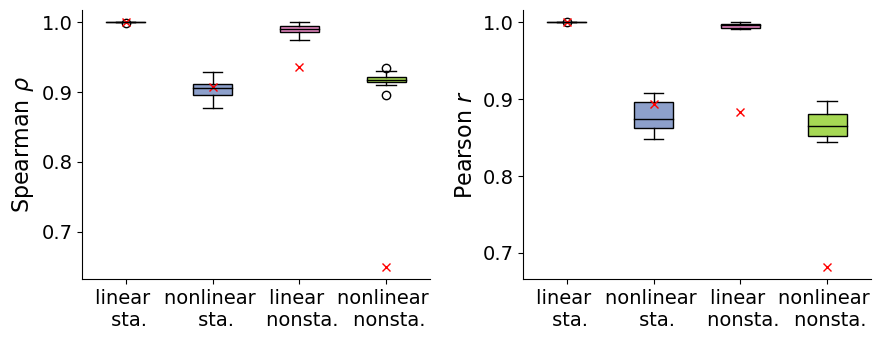

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
  
models = ['linear_static', 'tanh_static', 'linear_dynamic', 'tanh_dynamic']
labels = ['linear \n sta.', 'nonlinear \n sta.', 'linear \n nonsta.', 'nonlinear \n nonsta.']
cmap = plt.get_cmap('Set2')

toplot_spear = []
toplot_pearson = []
for i, md in enumerate(models):
    toplot_spear.append(spear_cc_allseeds_allmodels_1100epochs[md])
    toplot_pearson.append(pearson_cc_allseeds_allmodels_1100epochs[md])

### plot spearman correlation ###
bplot = axes[0].boxplot(toplot_spear, patch_artist=True)
for i, patch in enumerate(bplot['boxes']):
    patch.set_facecolor(cmap(1+i))

for median in bplot['medians']:
    median.set_color('black')
    
axes[0].set_xticks(np.arange(1, 1+len(models)))
axes[0].set_xticklabels(labels, fontsize=14)
axes[0].set_ylabel(r'Spearman $\rho$', fontsize=16)

for i, md in enumerate(models):
    axes[0].plot([i+1], [LR_results[md][2]], 'rx')

### plot pearson correlation ###
bplot = axes[1].boxplot(toplot_pearson, patch_artist=True)
for i, patch in enumerate(bplot['boxes']):
    patch.set_facecolor(cmap(1+i))

for median in bplot['medians']:
    median.set_color('black')
    
axes[1].set_xticks(np.arange(1, 1+len(models)))
axes[1].set_xticklabels(labels, fontsize=14)
axes[1].set_ylabel(r'Pearson $r$', fontsize=16)

for i, md in enumerate(models):
    axes[1].plot([i+1], [LR_results[md][3]], 'rx')

for ax in axes:
    ax.spines[['top', 'right']].set_visible(False)
    ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=14)

plt.tight_layout()
plt.show()

In [40]:
### statistical tests
for md in models:
    print(md)
    print('spearman corr', stats.ttest_1samp(spear_cc_allseeds_allmodels_1100epochs[md], popmean=LR_results[md][2]))
    print('pearson corr', stats.ttest_1samp(pearson_cc_allseeds_allmodels_1100epochs[md], popmean=LR_results[md][3]))

linear_static
spearman corr Ttest_1sampResult(statistic=-0.9999999999996309, pvalue=0.34343639613808263)
pearson corr Ttest_1sampResult(statistic=-1.6829810553404754, pvalue=0.12666983435485868)
tanh_static
spearman corr Ttest_1sampResult(statistic=-0.8066381619718379, pvalue=0.44066900597354763)
pearson corr Ttest_1sampResult(statistic=-2.369574006695489, pvalue=0.04193823029272793)
linear_dynamic
spearman corr Ttest_1sampResult(statistic=22.864424656955908, pvalue=2.780345468437527e-09)
pearson corr Ttest_1sampResult(statistic=117.94068465978553, pvalue=1.1501351307183711e-15)
tanh_dynamic
spearman corr Ttest_1sampResult(statistic=80.46650245717883, pvalue=3.579866713891155e-14)
pearson corr Ttest_1sampResult(statistic=33.150778222576456, pvalue=1.0184409034827303e-10)


# Visualize true and recovered connectivity matrices
For NetFormer: plot the seed with the average Spearman correlation

In [41]:
model_labels = ['linear sta.', 'nonlinear sta.', 'linear nonsta.', 'nonlinear nonsta.']

linear_static 0


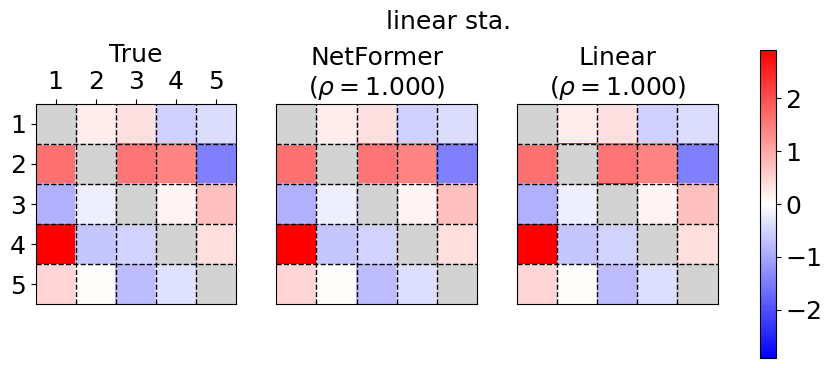

tanh_static 3


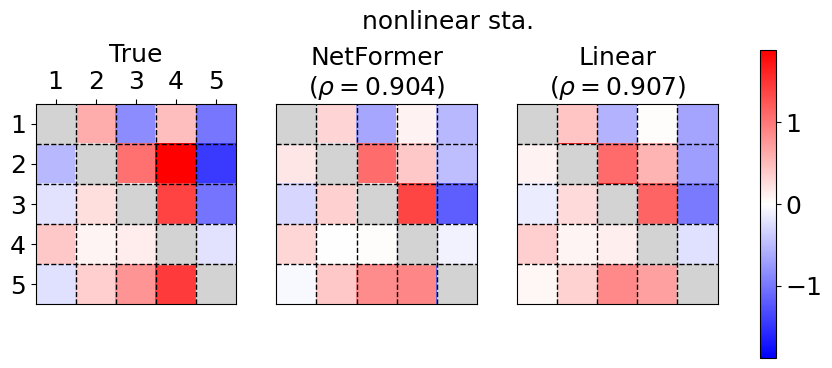

linear_dynamic 0


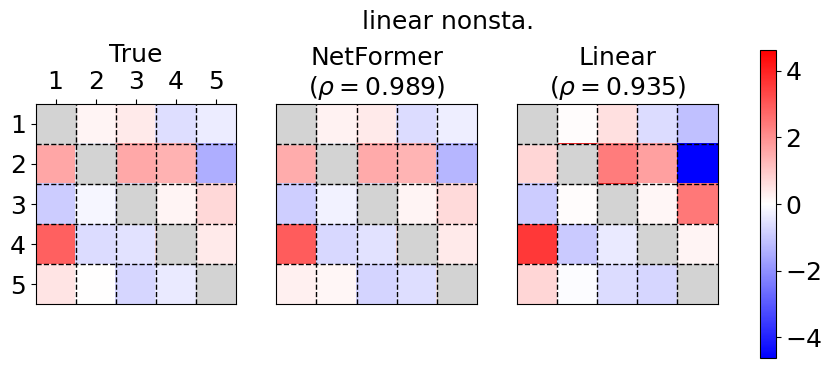

tanh_dynamic 2


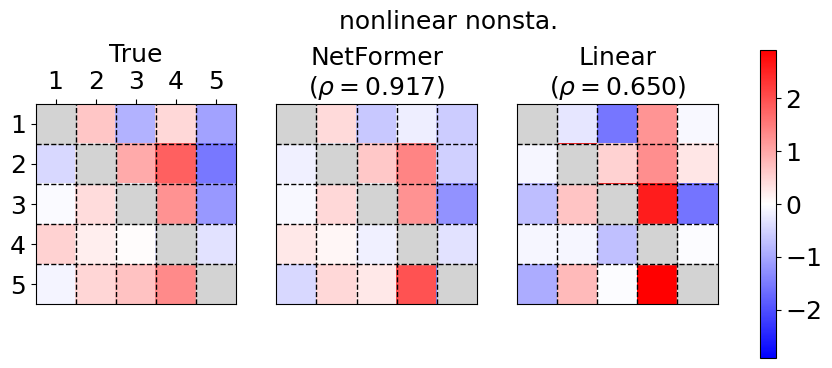

In [42]:
for im, md in enumerate(models):
    res_allseeds = spear_cc_allseeds_allmodels_1100epochs[md]
    seed_to_plot = np.argmin(np.abs(res_allseeds-np.mean(res_allseeds)))  # first find the seed to plot
    print(md, seed_to_plot)
    
    
    fig, axes = plt.subplots(1, 3, figsize=(11, 4))
    fig.suptitle(model_labels[im], fontsize=18)
    # set shared colorbar range
    GT = LR_results[md][1]
    A_avg = avg_attn = np.mean(attn_allseeds_allmodels_1100epochs[md][seed_to_plot], axis=0)
    A_ols = LR_results[md][0]

    plots = np.array([A_ols[offdiag_mask]/0.01, A_avg[offdiag_mask]/0.01, GT[offdiag_mask]])  # rescale attention by step size
    absvmax = np.max(np.abs(plots)) 

    ax = axes[0]
    ax.invert_yaxis()
    # ax.set_xticks([])
    # ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')

    c = ax.pcolor(GT, cmap='bwr', vmin=-absvmax, vmax=absvmax)
    for i in range(1, 5):
        ax.axhline(y=i, color='k', linestyle='--', linewidth=1)
        ax.axvline(x=i, color='k', linestyle='--', linewidth=1)
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(0.5, GT.shape[1], 1))
    ax.set_xticklabels([1, 2, 3, 4, 5])
    ax.set_yticks(np.arange(0.5, GT.shape[1], 1))
    ax.set_yticklabels([1, 2, 3, 4, 5])
    ax.tick_params(axis='x', which='major', labelsize=18)
    ax.tick_params(axis='y', which='major', labelsize=18)


    for i in range(5):
        ax.fill_between([i, i+1], i, i+1, color='lightgrey')
    ax.set_title(r'True', fontsize=18)

    ax = axes[1]
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')

    c = ax.pcolor(A_avg/0.01, cmap='bwr', vmin=-absvmax, vmax=absvmax)
    for i in range(1, 5):
        ax.axhline(y=i, color='k', linestyle='--', linewidth=1)
        ax.axvline(x=i, color='k', linestyle='--', linewidth=1)
    # ax.xaxis.tick_top()

    for i in range(5):
        ax.fill_between([i, i+1], i, i+1, color='lightgrey')
    ax.set_title('NetFormer\n'+r'($\rho=$'+f'{spear_cc_allseeds_allmodels_1100epochs[md][seed_to_plot]:.3f})', fontsize=18)

    ax = axes[2]
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')

    c = ax.pcolor(A_ols/0.01, cmap='bwr', vmin=-absvmax, vmax=absvmax)
    for i in range(1, 5):
        ax.axhline(y=i, color='k', linestyle='--', linewidth=1)
        ax.axvline(x=i, color='k', linestyle='--', linewidth=1)
    # ax.xaxis.tick_top()

    for i in range(5):
        ax.fill_between([i, i+1], i, i+1, color='lightgrey')
    ax.set_title('Linear\n'+r'($\rho=$'+f'{LR_results[md][2]:.3f})', fontsize=18)

    cbar = fig.colorbar(c, ax=axes.ravel().tolist())
    cbar.ax.tick_params(labelsize=18)

    plt.show()

# Visualize true and recovered activity
For NetFormer: plot the seed with the average Spearman correlation

linear_static 0
0.9999999998496303


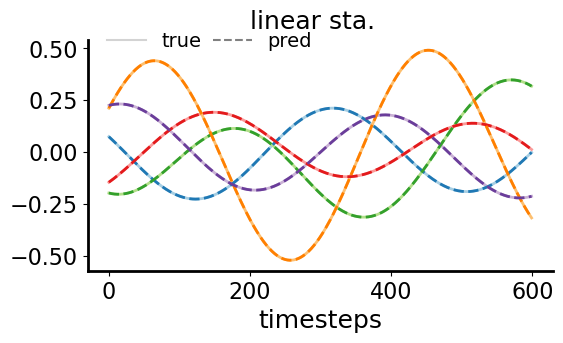

tanh_static 3
0.999999014374721


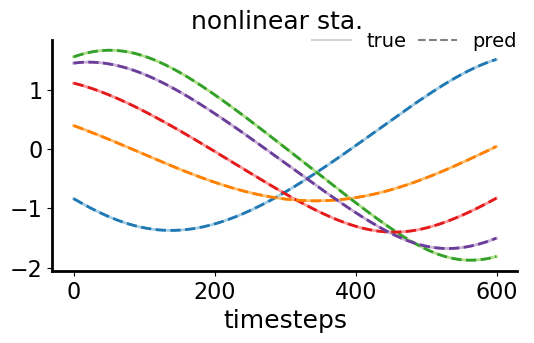

linear_dynamic 0
0.9999986956056743


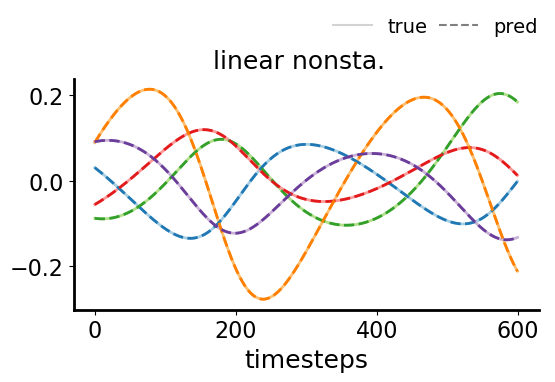

tanh_dynamic 2
0.9999993176072074


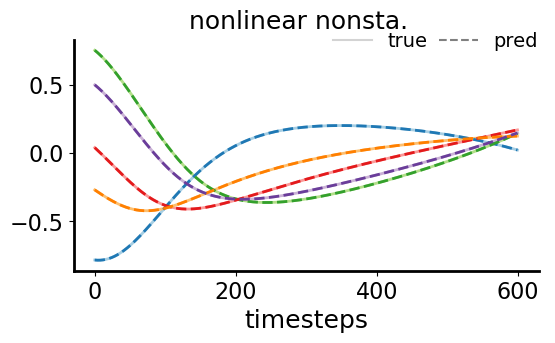

In [43]:
for im, md in enumerate(models):
    res_allseeds = spear_cc_allseeds_allmodels_1100epochs[md]
    seed_to_plot = np.argmin(np.abs(res_allseeds-np.mean(res_allseeds)))  # first find the seed to plot
    print(md, seed_to_plot)
    
    if md == 'linear_static':
        x_traj = simulate_linear5d_static(0.01, 5000)
        targets = x_traj[8:3000+8, :, :]        
    elif md == 'tanh_static':
        x_traj = simulate_tanh5d_static(0.01, 5000)
        targets = x_traj[8:3000+8, :, :]
    elif md == 'linear_dynamic':
        x_traj, W_traj = simulate_linear5d_dynamic(0.01, 5000)
        targets = x_traj[8:3000+8, :, :]
    elif md == 'tanh_dynamic':
        x_traj, W_traj = simulate_tanh5d_dynamic(0.01, 5000)
        targets = x_traj[8:3000+8, :, :]
   
    test_true = targets[int(targets.shape[0]*0.8):][:,:,0]
    test_pred = pred_allseeds_allmodels_1100epochs[md][seed_to_plot][:,:,0]

    fig, ax = plt.subplots(figsize=(6, 3))
    fig.suptitle(model_labels[im], fontsize=18)
    cmap = plt.get_cmap('Paired')
    for i in range(5):
        ax.plot(test_true[:,i], linewidth=2, c=cmap(2*i))
    for i in range(5):
        ax.plot(test_pred[:,i], '--', linewidth=2, c=cmap(2*i+1))

    ax.plot([], [], color='lightgrey', label='true')
    ax.plot([], [], '--', color='grey', label='pred')
    # ax.plot([], [], '-.', color='grey', label='pred (concat)')

    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.tick_params(axis='y', which='major', labelsize=16)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)

    print(r2_score(test_true[:,:], test_pred[:,:]))
    ax.spines[['top', 'right']].set_visible(False)
    ax.legend(bbox_to_anchor=(0.52, 1.11), ncol=3, columnspacing=0.6, frameon=False, fontsize=14)
    plt.xlabel('timesteps', fontsize=18)

    plt.show()

# For systems with time-varying connectivity, visualize attention across all timesteps

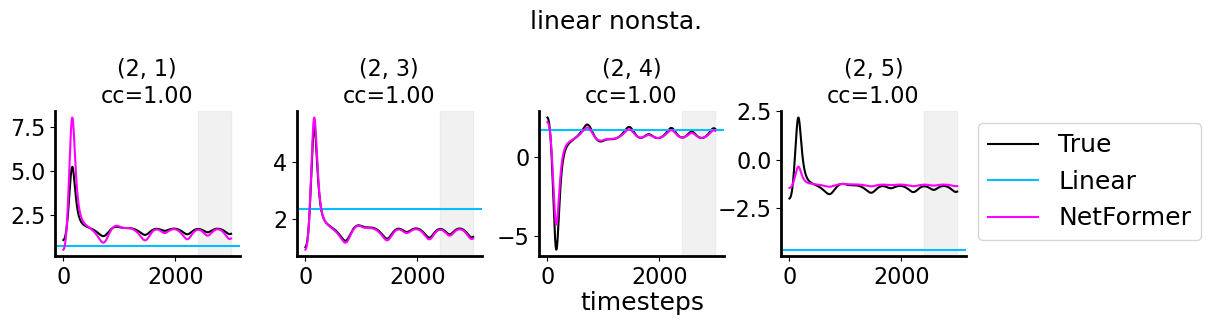

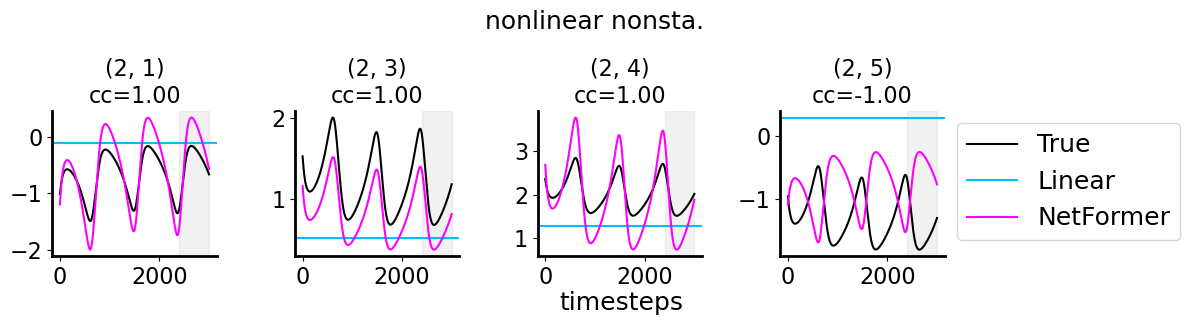

In [44]:
num_epochs = 1100
for md in ['linear_dynamic', 'tanh_dynamic']:
    if md == 'linear_dynamic':
        seed_to_plot = 0
        row_to_plot = 1
        x_traj, W_traj = simulate_linear5d_dynamic(0.01, 5000)
        title='linear nonsta.'
        gamma=0.8
    elif md == 'tanh_dynamic':
        seed_to_plot = 2
        row_to_plot = 1
        x_traj, W_traj = simulate_tanh5d_dynamic(0.01, 5000)
        title='nonlinear nonsta.'
        gamma=0.9
        
    inputs = torch.from_numpy(x_traj[7:3000+7, :, :]).float()
    targets = torch.from_numpy(x_traj[8:3000+8, :, :]).float()
    W_traj = W_traj[7:3000+7]
    total = targets.shape[0]
    inputs_train = inputs[:int(total*0.8)]
    targets_train = targets[:int(total*0.8)]
    train_dataset = TensorDataset(inputs_train, targets_train)
    torch.manual_seed(seed_to_plot)
    train_dataloader = DataLoader(train_dataset, batch_size=80, shuffle=True)
    model = NetFormer(nvar, input_dim, emb_dim, use_LN=False)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    # Training loop
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=gamma)
    for epoch in range(num_epochs):
        train_loss_epoch = train(train_dataloader, model, criterion, optimizer)
        train_losses.append(train_loss_epoch.item())
        scheduler.step()
    with torch.no_grad():
        all_pred, all_attn = model.attention(inputs)
        all_attn = all_attn.numpy()

    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    fig.suptitle(title, fontsize=18)
    j0 = 0
    for j in range(5):
        if j != row_to_plot:
            axes[j0].plot(W_traj[:, row_to_plot, j], '-k', label='True')
            axes[j0].axhline(LR_results[md][0][row_to_plot, j]*100, color='deepskyblue', linestyle='-', label='Linear')
            axes[j0].plot(all_attn[:, row_to_plot, j]*100, color='magenta', label='NetFormer')
            cc = np.corrcoef(W_traj[:, row_to_plot, j], all_attn[:, row_to_plot, j]*100)[0, 1]
            axes[j0].set_title(f'({row_to_plot+1}, {j+1})\ncc={cc:.2f}', fontsize=16)
            j0 +=1

    for ax in axes.ravel():
        ax.axvspan(xmin=2400, xmax=3000, color='lightgrey', alpha=0.3)
        ax.spines[['top', 'right']].set_visible(False)
        ax.tick_params(axis='x', which='major', labelsize=16)
        ax.tick_params(axis='y', which='major', labelsize=16)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)

    fig.text(0.47, -0.02, 'timesteps', fontsize=18)
    axes[-1].legend(bbox_to_anchor=(1, 1), fontsize=18)
    plt.tight_layout()
    plt.show()